In [3]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [6]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima.utils import decomposed_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf
from sklearn.preprocessing import MinMaxScaler

# Function to convert age range to a numerical value
def convertir_rango_edad_a_numero(rango_edad):
    return int(rango_edad // 3)

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate various metrics from model results
def calculo_metricas(results):
    residuals = results.resid
    
    mae = np.mean(np.abs(residuals))
    result = acorr_ljungbox(residuals, period=52)
    mse = np.mean(residuals**2)
    rmse = np.sqrt(mse)
    p_value = round(result.lb_pvalue.mean(), 3)
    
    return mae, mse, rmse, results.aic, results.bic, p_value

# Function to create a summary table from model results
def summary_table(results):
    summary_table = results.summary().tables[1]
    
    # Convert the summary table to a DataFrame
    summary_df = pd.DataFrame(summary_table.data[1:], columns=summary_table.data[0])
    
    # Clean up the DataFrame
    summary_df = summary_df.apply(pd.to_numeric, errors='ignore')
    
    # Rename columns for better access
    summary_df.columns = ['variable', 'coef', 'std_err', 'z', 'P>|z|', '[0.025', '0.975]']
    
    return summary_table


In [7]:
df_f=pd.read_csv("Bases//Base_Limpia_Added.csv")

In [8]:
df_f["provincia"].unique()

df_c0=pd.read_csv("Bases//Base_Casos_Act.csv")


cols_clima=['salud',"densidad_estimada","index obesity","TEMP","HUM","PNM","DD","FF"]

# After a lot of runs the poverty data didnt improve the model, this could is probably because is not temporal data, it only refer to one moment of the census
cols_pobreza=['% de hogares sin acceso a red cloacal','% de población en situación de pobreza crónica','% de población sin obra social ni prepaga'] # Mejor
cols_pobreza=['% de hogares sin acceso a red cloacal','% de población en situación de pobreza crónica']
cols_pobreza=[ 'Nivel de incidencia de pobreza crónica','% de hogares con hacinamiento crítico','% de hogares en vivienda deficitaria','% de hogares sin acceso a red cloacal','% de población en situación de pobreza crónica','% de población sin obra social ni prepaga']
cols_pobreza=['% de hogares sin acceso a red cloacal','% de población en situación de pobreza crónica','% de población sin obra social ni prepaga'] # Mejor

cols_pobreza=[ 'Nivel de incidencia de pobreza crónica','% de hogares con hacinamiento crítico','% de hogares en vivienda deficitaria','% de hogares sin acceso a red cloacal','% de población en situación de pobreza crónica','% de población sin obra social ni prepaga']

cols_pobreza=[]
cols_pred=cols_clima+cols_pobreza

# Select the province or provinces for run the models
l_provincias=[]

l_provincias=["Santa Fe"]

l_provincias=["CABA"]







l_provincias=["Buenos Aires","CABA"]

l_provincias=["Salta","Jujuy"]

# ARIMA and SARIMAX Models

In [9]:
def pre_process(l_p, df_c0, df_f, cols_pred):
    """
    Pre-processes tuberculosis incidence and climate data for specific provinces.

    Input:
    - l_p (list): List of provinces to filter data. If empty, processes data for all provinces.
    - df_c0 (DataFrame): DataFrame containing COVID-19 data.
    - df_f (DataFrame): DataFrame containing climate and poverty data.
    - cols_pred (list): List of columns to use as predictors in the analysis.

    Output:
    - df_f2 (DataFrame): Processed DataFrame containing normalized climate and poverty data along with COVID-19 cases.
    - promedio_por_dia (DataFrame): DataFrame with daily averages of predictors.
    - promedio_por_semana (DataFrame): DataFrame with weekly averages of predictors.

    Steps:
    1. Filters data based on the provinces provided in `l_p` or uses all data if `l_p` is empty.
    2. Normalizes columns in `df_f` except 'fecha' using MinMaxScaler.
    3. Computes daily and weekly averages of predictors from `df_f`.
    4. Interpolates missing values in `df_f2`.
    """
    # Step 1: Filter data based on provinces
    if len(l_p) == 0:
        df_cc = df_c0.copy()
        df_f2 = df_f.copy()[cols_pred + ["fecha"]]
    else:
        df_cc = df_c0.loc[df_c0["provincia"].isin(l_p)]
        df_f2 = df_f.loc[df_f["provincia"].isin(l_p)][cols_pred + ["fecha"]]

    # Drop 'provincia' column
    df_cc.drop(["provincia"], axis=1, inplace=True)

    # Step 2: Normalize columns in df_f2 except 'fecha'
    columns_to_normalize = df_f2.columns.difference(['fecha'])
    scaler = MinMaxScaler()
    df_f2 = df_f2.copy()
    df_f2[columns_to_normalize] = scaler.fit_transform(df_f2[columns_to_normalize])
    df_f2['fecha'] = pd.to_datetime(df_f2['fecha'])

    # Step 3: Compute daily and weekly averages of predictors in df_f2
    promedio_por_dia = df_f2.groupby(df_f2['fecha'].dt.to_period('D'))[cols_pred].mean()
    promedio_por_semana = df_f2.groupby(df_f2['fecha'].dt.to_period('W-Mon'))[cols_pred].mean()

    # Step 4: Merge COVID-19 cases with climate and poverty data by week
    df_cc['fecha'] = pd.to_datetime(df_cc['fecha'])
    incidencia_por_semana2 = df_cc.groupby(df_cc['fecha'].dt.to_period('W-Mon'))['casos_corr_2'].sum()
    incidencia_por_semana2 = incidencia_por_semana2.reset_index()

    df_f2 = pd.merge(pd.DataFrame(incidencia_por_semana2, columns=["fecha", "casos_corr_2"]),
                     pd.DataFrame(promedio_por_semana), on="fecha", how="left")
    df_f2 = df_f2.rename(columns={"casos_corr_2": "Casos"})

    # Additional processing: Convert 'fecha' to datetime and interpolate missing values
    df_f2['fecha'] = pd.to_datetime(df_f2['fecha'].astype(str).str.split('/').str[0])
    df_f2 = df_f2.interpolate()

    return df_f2, promedio_por_dia, promedio_por_semana


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
def easy_models(df_f2, cols_pred, test_ratio=0.2):
    """
    Runs and evaluates multiple time series models on COVID-19 data with train-test split.
    Metrics are calculated based on test data.

    Input:
    - df_f2 (DataFrame): Processed DataFrame containing normalized climate, poverty, and COVID-19 case data.
    - cols_pred (list): List of columns used as predictors in the analysis.
    - test_size (float): Proportion of the dataset to include in the test split (default is 0.2).

    Output:
    - arima_results (str): Summary table of ARIMA model results.
    - arimax_results (str): Summary table of ARIMAX model results.
    - sarima_results (str): Summary table of SARIMA model results.
    - sarimax_results (str): Summary table of SARIMAX model results.
    - df_metrics (DataFrame): DataFrame containing evaluation metrics (MAE, MSE, RMSE, AIC, BIC, p-value) for each model.
    """
    split_index = int(len(df_f2) * (1 - test_ratio))
    train = df_f2.iloc[:split_index]
    test = df_f2.iloc[split_index:]
    
    # Function to calculate metrics for test data
    def calculate_test_metrics(model, test, exog=None):
        predictions = model.forecast(steps=len(test), exog=exog)
        mae = mean_absolute_error(test['Casos'], predictions)
        mse = mean_squared_error(test['Casos'], predictions)
        rmse = np.sqrt(mse)
        return mae, mse, rmse

    metrics = []
    
    # ARIMA model without exogenous variables
    model = sm.tsa.ARIMA(train['Casos'], order=(1, 1, 1))
    results = model.fit()
    print("ARIMA results")
    arima_results = summary_table(results)
    mae, mse, rmse = calculate_test_metrics(results, test)
    arima_metrics = [mae, mse, rmse, results.aic, results.bic, results.pvalues[0]]
    metrics.append(arima_metrics)

    # ARIMAX model with exogenous variables
    model = sm.tsa.ARIMA(train['Casos'], exog=train[cols_pred], order=(1, 1, 1))
    results = model.fit()
    print("ARIMAX results")
    arimax_results = summary_table(results)
    mae, mse, rmse = calculate_test_metrics(results, test, exog=test[cols_pred])
    arimax_metrics = [mae, mse, rmse, results.aic, results.bic, results.pvalues[0]]
    metrics.append(arimax_metrics)

    # Auto ARIMA model selection
    print("Auto model results")
    auto_model = auto_arima(train['Casos'], max_p=8, max_d=8, max_q=8)
    print(auto_model.summary())
    p_best, d_best, q_best = auto_model.order

    # SARIMA model
    order = (p_best, d_best, q_best)
    model = sm.tsa.SARIMAX(train['Casos'], order=order)
    results = model.fit()
    sarima_results = summary_table(results)
    print("SARIMA results")
    mae, mse, rmse = calculate_test_metrics(results, test)
    sarima_metrics = [mae, mse, rmse, results.aic, results.bic, results.pvalues[0]]
    metrics.append(sarima_metrics)

    # SARIMAX model with exogenous variables
    model = sm.tsa.SARIMAX(train['Casos'], order=order, exog=train[cols_pred])
    results = model.fit()
    sarimax_results = summary_table(results)
    print("SARIMAX results")
    mae, mse, rmse = calculate_test_metrics(results, test, exog=test[cols_pred])
    sarimax_metrics = [mae, mse, rmse, results.aic, results.bic, results.pvalues[0]]
    metrics.append(sarimax_metrics)

    # Combine metrics into DataFrame for easy comparison
    model_names = [
        "ARIMA (1,1,1)", 
        "ARIMAX (1,1,1)", 
        f"SARIMA ({p_best},{d_best},{q_best})", 
        f"SARIMAX ({p_best},{d_best},{q_best})"
    ]
    df_metrics = pd.DataFrame(metrics, columns=["mae", "mse", "rmse", "AIC", "BIC", "p-value"])
    df_metrics["Model Name"] = model_names

    return arima_results, arimax_results, sarima_results, sarimax_results, df_metrics
# Example usage:
for l_p in [l_provincias]:
    print(l_p)
    df_f2, promedio_dia, promedio_por_semana = pre_process(l_p, df_c0, df_f, cols_pred)
    arima_results, arimax_results, sarima_results, sarimax_results, df_metrics = easy_models(df_f2, cols_pred)

['Salta', 'Jujuy']
ARIMA results


c:\Users\Nainh\miniconda3\envs\automatic\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMAX results
Auto model results
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  584
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1551.425
Date:                Wed, 15 Oct 2025   AIC                           3110.851
Time:                        13:33:05   BIC                           3128.323
Sample:                             0   HQIC                          3117.661
                                - 584                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2905      0.043      6.835      0.000       0.207       0.374
ar.L2          0.2467      0.043      5.760      0.000       0.163       0.331
ma.L1         -0.9

c:\Users\Nainh\miniconda3\envs\automatic\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
best_rmse=df_metrics.loc[df_metrics["p-value"]<0.05]["rmse"].min()
best_rmse

np.float64(5.803371457029742)

In [12]:
def simple_table_to_df(simple_table):
    """
    Convert a simple table structure into a Pandas DataFrame.
    
    Parameters:
    - simple_table (object): A structured data object representing a table.
    
    Returns:
    - df (DataFrame): Pandas DataFrame containing the table data.
    """
    data = simple_table.data[1:]  # Skip the header row, assuming data starts from the second row
    headers = simple_table.data[0]  # Use the first row as headers
    
    # Create DataFrame with extracted data and headers
    df = pd.DataFrame(data, columns=headers)
    
    # Convert all columns to numeric (ignore errors if conversion fails)
    df = df.apply(pd.to_numeric, errors='ignore')
    
    return df

def best_variables(arimax_results, sarimax_results, best_sarimax):
    """
    Consolidates and compares coefficients and statistical significance (P-values) 
    of variables from different model results (ARIMAX, SARIMAX, and best-performing SARIMAX).

    Inputs:
    - arimax_results: Summary table or data structure from ARIMAX model results.
    - sarimax_results: Summary table or data structure from SARIMAX model results.
    - best_sarimax: Detailed results from the best-performing SARIMAX model.

    Outputs:
    - df_final: Pandas DataFrame with variables as rows and columns representing 
      coefficients (coef) and statistical significance (P>|z|) from ARIMAX, SARIMAX, 
      and best-performing SARIMAX models.
    """
    # Extract relevant columns from ARIMAX and SARIMAX results
    df1 = simple_table_to_df(arimax_results)[["", "coef", "P>|z|"]].add_suffix('_ARIMAX')
    df2 = simple_table_to_df(sarimax_results)[["", "coef", "P>|z|"]].add_suffix('_SARIMAX')
    
    # Extract relevant columns from best SARIMAX results
    df3 = simple_table_to_df(best_sarimax["results"])[["", "coef", "P>|z|"]].add_suffix('_SARIMAX_BEST')

    # Rename columns for merging and comparison
    df1 = df1.rename(columns={'_ARIMAX': 'variable'})
    df2 = df2.rename(columns={'_SARIMAX': 'variable'})
    df3 = df3.rename(columns={'_SARIMAX_BEST': 'variable'})

    # Merge DataFrames on 'variable' column
    df_final = pd.merge(df1, df2, on="variable", how="left")
    df_final = pd.merge(df_final, df3, on="variable", how="left")[:-3]  # Remove last 3 rows (assuming they are footer rows)

    # Filter final DataFrame based on significance levels
    df_final = df_final.loc[(df_final["P>|z|_ARIMAX"] < 0.15) | (df_final["P>|z|_SARIMAX"] < 0.05) | (df_final["P>|z|_SARIMAX_BEST"] < 0.15)]

    return df_final



In [13]:
import warnings
warnings.filterwarnings("ignore")
def grid_search(df_f2, best_rmse, model_="SARIMAX"):
    """
    Performs a grid search to find the best SARIMA/SARIMAX model based on RMSE and p-value criteria.

    Input:
    - df_f2 (DataFrame): Processed DataFrame containing normalized climate, poverty, and COVID-19 case data.
    - best_rmse (float): Best RMSE value obtained from initial model evaluation.
    - model_ (str): Type of model to perform grid search ('SARIMAX' or 'ARIMA').

    Output:
    - df_best (DataFrame): DataFrame containing metrics and results of best-performing models from grid search.
    """
    l_metrics = []
    p, d, q = 4, 2, 4  # Define search ranges for p, d, q
    print(f"max p, d, q: {p}, {d}, {q}")

    # Perform grid search over defined parameter ranges
    for p_ in range(p):
        for d_ in range(d):
            for q_ in range(q):
                order = (p_, d_, q_)  # ARIMA/SARIMA order parameters

                try:
                    if model_ == "SARIMAX":
                        model = sm.tsa.SARIMAX(df_f2['Casos'], exog=df_f2[cols_pred], order=order)
                    elif model_ == "ARIMA":
                        model = sm.tsa.ARIMA(df_f2['Casos'], exog=df_f2[cols_pred], order=order)

                    results = model.fit()
                    results.fittedvalues[0] = results.fittedvalues.mean()  # Adjust first fitted value

                    # Calculate metrics
                    mae, mse, rmse, aic, bic, p_value = calculo_metricas(results)

                    # Store results if RMSE is lower than current best and p-value is significant
                    if (rmse <= best_rmse) and (p_value<0.05):
                        best_results = summary_table(results)
                        # display(best_results)
                        print(p_, d_, q_)
                        # if p_value < 0.06:
                        #     print(results.summary())
                        print(mae, mse, rmse, aic, bic, p_value)
                        values = (p_, d_, q_, mae, mse, rmse, aic, bic, p_value, best_results)
                        l_metrics.append(values)

                except:
                    print("Error encountered in model fitting")

    # Create DataFrame from collected metrics and results
    df_best = pd.DataFrame(l_metrics)
    df_best["NAME"] = "SARIMAX ("+df_best[0].astype(str) +", "+df_best[1].astype(str) +", "+df_best[2].astype(str)+" )"

    df_best.drop([0, 1, 2], axis=1, inplace=True)
    df_best.columns = ["mae", "mse", "rmse", "AIC", "BIC", "p-value", "results", "Model Name"]

    return df_best

def best_sarimax(df_metrics, model_):
    """
    Identifies the best SARIMA/SARIMAX model based on p-value and RMSE criteria.

    Input:
    - df_metrics (DataFrame): DataFrame containing evaluation metrics for multiple SARIMA/SARIMAX models.
    - model_ (str): Type of model to consider ('SARIMAX' or 'ARIMA').

    Output:
    - df_metrics (DataFrame): Updated DataFrame with details of the best-performing SARIMA/SARIMAX model.
    - df_best (DataFrame): DataFrame containing metrics and results of best-performing models.
    """
    # Display metrics for models with p-value < 0.05
    display(df_metrics[df_metrics["p-value"] < 0.05])

    # Find the best RMSE among models with significant p-value
    best_rmse = df_metrics.loc[df_metrics["p-value"] < 0.05]["rmse"].min()

    # Perform grid search to find best model based on updated RMSE criteria
    df_best = grid_search(df_f2, best_rmse, model_)

    # Identify the best SARIMAX model with p-value < 0.06 and lowest RMSE
    best_sarimax = df_best.loc[df_best["p-value"] < 0.06].sort_values(by="rmse").iloc[0]

    # Append best SARIMAX model details to df_metrics and round values for clarity
    df_metrics.loc[-1] = best_sarimax
    df_metrics = df_metrics.reset_index(drop=True).round(2)

    return df_metrics, df_best


# Filter df_metrics to select rows where the model name starts with "SARIMAX"
# and the p-value is less than or equal to 0.1, indicating statistical significance.
sarimax_true = df_metrics.loc[(df_metrics["Model Name"].str[:7] == "SARIMAX") & (df_metrics["p-value"] <= 0.1)]

# Specify the model type to focus on for further analysis and comparison.
model_best = "SARIMAX"

# Call the function best_sarimax to identify and extract the best-performing SARIMAX model
# from df_metrics based on predefined criteria.
df_metrics_, df_best = best_sarimax(df_metrics, model_best)


,mae,mse,rmse,AIC,BIC,p-value,Model Name
0,4.802216,33.679120,5.803371,3139.558871,3152.663433,8.456700e-10,"ARIMA (1,1,1)"
2,5.164057,38.155911,6.177047,3110.850698,3128.323447,8.209158e-12,"SARIMA (2,1,1)"


max p, d, q: 4, 2, 4
0 0 0
3.6118380125161424 20.75532260796681 4.555800984236122 4309.466927528092 4350.81664866584 0.0
0 0 1
3.3471350124439927 17.72027836637934 4.209546099804507 4195.958392418397 4241.9025270158945 0.0
0 0 2
3.142302590607436 15.668161631137401 3.9583028725878724 4107.827539974606 4158.366088031854 0.001
0 0 3
3.058237173963949 14.98862260733231 3.8715142525027995 4077.5765742091776 4132.709535726175 0.01
0 1 0
3.343189033899427 17.826682944029155 4.222165669893728 4175.680059846696 4217.017460653978 0.0
0 1 1
2.8960166002570813 13.811851773566927 3.71642997694924 3986.1662419573922 4032.0966872988165 0.001
0 1 2
2.893431128850143 13.69305318417106 3.700412569453717 3982.5838664343246 4033.107356309891 0.003
0 1 3
2.802566723085508 13.061513735183976 3.6140716283969767 3948.0256409923113 4003.1421754020207 0.012
1 0 0
3.1241352678911203 15.634589936802092 3.9540599308561437 4104.685034686983 4150.629169284481 0.0
1 0 1
2.8911105502206023 13.787577659007098 3.713162

In [14]:
df_metrics_

,mae,mse,rmse,AIC,BIC,p-value,Model Name
0,4.80,33.68,5.80,3139.56,3152.66,0.00,"ARIMA (1,1,1)"
1,4.78,34.56,5.88,3130.46,3178.51,0.88,"ARIMAX (1,1,1)"
2,5.16,38.16,6.18,3110.85,3128.32,0.00,"SARIMA (2,1,1)"
3,5.10,38.80,6.23,3113.01,3165.43,0.97,"SARIMAX (2,1,1)"
4,2.72,12.25,3.50,3905.14,3974.04,0.04,"SARIMAX (3, 1, 3 )"


In [15]:
# Save df_metrics DataFrame to a CSV file with a filename based on l_provincias
df_metrics_.to_csv("Resultados\\Tseries_Metricas" + str(l_provincias) + ".csv", index=False)

# Extract the detailed results DataFrame of the best-performing model (last row in df_best) and format it
df_variables = pd.DataFrame(df_best.iloc[-1]["results"])

# Rename the first column to "variable" and set it as the header row
df_variables[0].iloc[0] = "variable"
df_variables.columns = df_variables.iloc[0]

# Remove the first row (header row) to keep only the data rows
df_variables = df_variables[1:]
df_variables.columns=['variable','coef','std err','z','P>|z|','[0.025','0.975]']

df_variables

,variable,coef,std err,z,P>|z|,[0.025,0.975]
1,salud,-0.2555,1.250,-0.204,0.838,-2.705,2.194
2,densidad_estimada,-4.3150,3.084,-1.399,0.162,-10.359,1.729
3,index obesity,5.7255,4.603,1.244,0.214,-3.297,14.748
4,TEMP,3.4028,1.593,2.136,0.033,0.280,6.526
5,HUM,-3.2165,1.619,-1.987,0.047,-6.390,-0.043
6,PNM,4.1337,4.420,0.935,0.350,-4.529,12.796
7,DD,-1.1881,2.932,-0.405,0.685,-6.934,4.558
8,FF,3.0279,3.172,0.954,0.340,-3.190,9.245
9,ar.L1,-1.4823,0.041,-35.725,0.000,-1.564,-1.401
10,ar.L2,-0.1271,0.079,-1.609,0.108,-0.282,0.028


In [16]:
for c in df_variables.columns[1:]:
    df_variables[c]=df_variables[c].astype(str).astype(float)
# Save df_variables DataFrame to a CSV file with a filename based on l_provincias
df_variables.to_csv("Resultados\\Tseries_Variables" + str(l_provincias) + ".csv", index=False)
df_variables.to_excel("Resultados\\Tseries_Variables" + str(l_provincias) + ".xlsx", index=False)

In [17]:
# Read the variables DataFrame from the CSV file and round numeric values to two decimal places
df_variables = pd.read_csv("Resultados\\Tseries_Variables" + str(l_provincias) + ".csv").round(2)

# Check if there is an 'Unnamed: 0' column in df_variables and drop it if present
if "Unnamed: 0" in df_variables.columns:
    df_variables.drop("Unnamed: 0", axis=1, inplace=True)

# Read the metrics DataFrame from the CSV file and round numeric values to two decimal places
df_metrics = pd.read_csv("Resultados\\Tseries_Metricas" + str(l_provincias) + ".csv").round(2)
display(df_metrics)
# Check if there is an 'Unnamed: 0' column in df_metrics and drop it if present
if "Unnamed: 0" in df_metrics.columns:
    df_metrics.drop("Unnamed: 0", axis=1, inplace=True)

# Convert columns 'AIC' and 'BIC' in df_metrics to integer type
for s in ["AIC", "BIC"]:
    df_metrics[s] = df_metrics[s].astype(int)

# Create a copy of df_metrics for auxiliary purposes
df_aux = df_metrics.copy()

# Drop the 'Model Name' column from df_metrics
df_metrics.drop("Model Name", axis=1, inplace=True)

# Concatenate the 'Model Name' column back to df_metrics after processing
df_metrics = pd.concat([df_aux[["Model Name"]], df_metrics], axis=1)

# Print the list of provinces l_provincias
print(l_provincias)

# Display or return df_metrics for further analysis or visualization
df_metrics=df_metrics.rename(columns={"mse":"MSE","rmse":"RMSE","mae":"MAE"})
# Save df_metrics DataFrame to a CSV file with a filename based on l_provincias
df_metrics.to_excel("Resultados\\Tseries_Metricas" + str(l_provincias) + ".xlsx", index=False)


,mae,mse,rmse,AIC,BIC,p-value,Model Name
0,4.80,33.68,5.80,3139.56,3152.66,0.00,"ARIMA (1,1,1)"
1,4.78,34.56,5.88,3130.46,3178.51,0.88,"ARIMAX (1,1,1)"
2,5.16,38.16,6.18,3110.85,3128.32,0.00,"SARIMA (2,1,1)"
3,5.10,38.80,6.23,3113.01,3165.43,0.97,"SARIMAX (2,1,1)"
4,2.72,12.25,3.50,3905.14,3974.04,0.04,"SARIMAX (3, 1, 3 )"


['Salta', 'Jujuy']


In [18]:
df_aux[["Model Name"]]

,Model Name
0,"ARIMA (1,1,1)"
1,"ARIMAX (1,1,1)"
2,"SARIMA (2,1,1)"
3,"SARIMAX (2,1,1)"
4,"SARIMAX (3, 1, 3 )"


# LSTM Model

In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Filter df_c0 by provinces in l_p


# # Convert 'fecha' column in df_f2 to datetime
# df_f2['fecha'] = pd.to_datetime(df_f2['fecha'])

# # Aggregate daily cases into weekly using W-Mon frequency
df_daily = df_f2.groupby(df_f2['fecha'].dt.to_period('W-Mon'))['Casos'].sum().reset_index(name='cases')

# # Scale 'cases' using MinMaxScaler to range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
df_daily['cases_scaled'] = scaler.fit_transform(df_daily['cases'].values.reshape(-1, 1))

# Convert promedio_dia and promedio_por_semana to DataFrames

df_cc = df_c0.loc[df_c0["provincia"].isin(l_p)]
prom_dia_variables = pd.DataFrame(promedio_dia.to_records())
# promedio_por_semana = pd.DataFrame(promedio_por_semana.to_records())

# Convert 'fecha' column to string for merging
prom_dia_variables["fecha"] = prom_dia_variables["fecha"].astype(str)
df_ccc = df_cc[["fecha", "casos_corr_2"]]
df_ccc["fecha"] = df_ccc["fecha"].astype(str)

# Merge prom_dia_variables and df_ccc on 'fecha'
df_data = pd.merge(prom_dia_variables, df_ccc, on=["fecha"], how="left")

# Set 'fecha' column as index and drop it from DataFrame
df_data.index = df_data["fecha"]
df_data = pd.DataFrame(df_data.drop("fecha", axis=1))

# Function to create sequences for LSTM input
def create_sequences(df, seq_length):
    xs = []
    ys = []
    for i in range(len(df) - seq_length):
        x = df.iloc[i:(i + seq_length), 1:].values  # Predictor variables (x1, x2, ..., xn)
        y = df.iloc[i + seq_length, 0]              # Target time series (y)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Sequence length for LSTM model
seq_length = 10

# Impute missing values in predictor variables
imputer_X = SimpleImputer(strategy='mean')
X_imputed = imputer_X.fit_transform(df_data.drop(columns=["casos_corr_2"]).values)

# Impute NaN values in target variable
imputer_y = SimpleImputer(strategy='mean')
y_imputed = imputer_y.fit_transform(df_data["casos_corr_2"].values.reshape(-1, 1))

# Create sequences for LSTM input
X_seq, y_seq = create_sequences(pd.DataFrame(X_imputed), seq_length)

# Split data into training and test sets
split_ratio = 0.8
split = int(len(X_seq) * split_ratio)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Reshape input dimensions for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Function to define the LSTM model
def rnn_model(X_train,y_train,X_test,y_test):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

    return model

load = 0

# Create and train the LSTM model
model= rnn_model(X_train,y_train,X_test,y_test)

# Print model summary
model.summary()

# Evaluate the model using test data
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow.keras.backend as K

# Function to calculate log-likelihood
def calculate_log_likelihood(mse, n):
    return -n/2 * np.log(2 * np.pi * mse) - n/2

# Inverse transform predictions and test data to original scale
y_pred_2 = scaler.inverse_transform(y_pred)
y_test_2 = scaler.inverse_transform([y_test])

# Function to count trainable parameters in the model
def count_parameters(model):
    return sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])

# Number of parameters in the model
num_params = count_parameters(model)

# Number of observations
n = len(y_test_2[0])

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_2[0], y_pred_2[:, 0])

# Calculate log-likelihood
log_likelihood = calculate_log_likelihood(mse, n)

# Calculate Akaike Information Criterion (AIC)
aic = 2 * num_params - 2 * log_likelihood

# Calculate Bayesian Information Criterion (BIC)
bic = np.log(n) * num_params - 2 * log_likelihood

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Loglikelihood: {round(log_likelihood, 2)}')
print(f"AIC: {round(aic, 2)}")
print(f"BIC: {round(bic, 2)}")
print(f"MSE: {round(mse, 2)}")
print(f'RMSE: {round(rmse, 3)}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_2[0], y_pred_2[:, 0])
print(f'Mean Absolute Error (MAE): {round(mae, 2)}')


Loglikelihood: -2644.26
AIC: 574290.51
BIC: 1968839.65
MSE: 11.97
RMSE: 3.46
Mean Absolute Error (MAE): 2.29


In [ ]:
# Select the last row of df_metrics and assign it to df_final
df_final = df_metrics[-1:]

# Append a new row for the LSTM model to df_final
df_final.loc[-1] = ['LSTM Model', round(mae, 2), round(mse, 2), round(rmse, 3), round(aic, 2), round(bic, 2), '']

# Drop the 'p-value' column from df_final (if it exists)
df_final.drop(["p-value"], axis=1, inplace=True)

# Reset the index of df_final
df_final = df_final.reset_index(drop=True)

# Convert 'AIC' column to integer type
df_final["AIC"] = df_final["AIC"].astype(int)

# Round 'rmse' column to 2 decimal places
df_final["RMSE"] = df_final["RMSE"].round(2)

# Convert 'BIC' column to integer type
df_final["BIC"] = df_final["BIC"].astype(int)

# Display df_final
df_final


,Model Name,MAE,MSE,RMSE,AIC,BIC
0,"SARIMAX (1, 1, 3 )",2.93,14.60,3.82,4050,4110
1,LSTM Model,2.29,11.97,3.46,574290,1968839


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


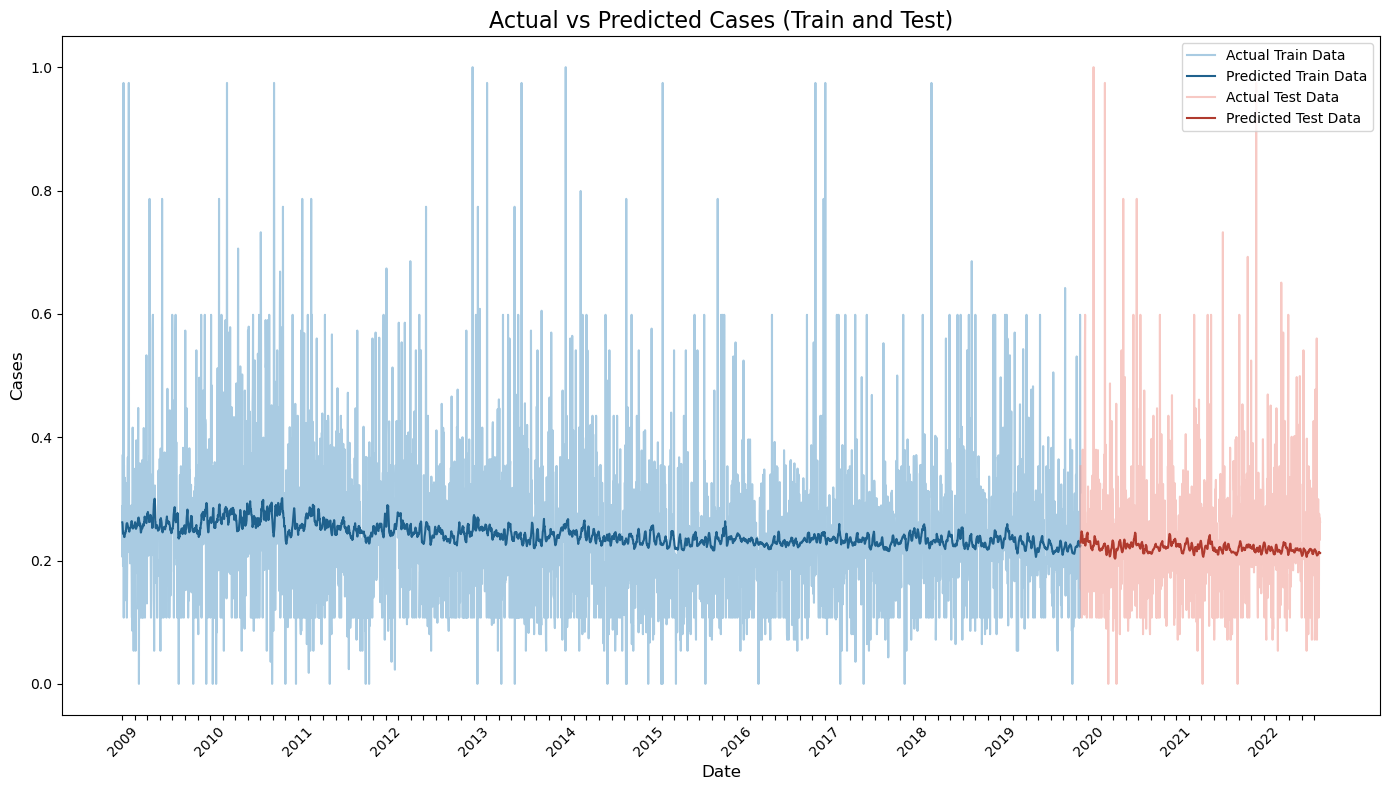

In [ ]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted data for both training and test sets
plt.figure(figsize=(14, 8))

# Plot training data
plt.plot(y_train, label='Actual Train Data', color='#5499C7', alpha=0.5)

# Plot predicted training data
y_pred_train = model.predict(X_train)
plt.plot(y_pred_train, label='Predicted Train Data', color='#1F618D')

# Plot test data
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual Test Data', color='#F1948A', alpha=0.5)

# Plot predicted test data
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred, label='Predicted Test Data', color='#B03A2E')

# Add labels and title
plt.xlabel('Date',fontsize=12)
plt.ylabel('Cases',fontsize=12)
plt.title('Actual vs Predicted Cases (Train and Test)',fontsize=16)
plt.legend()


ticks = np.arange(0, len(y_train) + len(y_test), 52)

# Create labels array
labels = []
year=2009

for i in range(len(ticks)):

    if i % 7 == 0:
        
        labels.append(year)
        year=year+1
    else:
        labels.append("")

plt.xticks(ticks=ticks, labels=labels, rotation=45)

# Show plot
plt.tight_layout()
plt.savefig("Documentacion\\figures\\lstm_pred_"+str(l_provincias)+".png",dpi=310)
plt.show()

In [ ]:
# Número de semanas a predecir
n_weeks_to_predict = 124

# Predecir las próximas semanas
predictions = []
current_input = X_train[-1].copy()  # Usar la última secuencia de entrenamiento como punto de partida

for _ in range(n_weeks_to_predict):
    # Predecir el siguiente valor
    pred = model.predict(current_input[np.newaxis, ...])
    
    # Almacenar la predicción
    predictions.append(pred[0, 0])  # Se asume que la salida es un escalar

    # Actualizar current_input: 
    # Reemplazar la primera fila de current_input con la predicción
    current_input = np.roll(current_input, -1, axis=0)  # Mover las filas hacia arriba
    current_input[-1, 0] = pred[0, 0]  # Asignar la nueva predicción a la última fila

# Convertir las predicciones a un array de NumPy
predictions = np.array(predictions)

# Desescalar las predicciones
predictions_descaled = scaler.inverse_transform(predictions.reshape(-1, 1))

# Crear un rango de fechas para las predicciones
last_date = df_daily['fecha'].dt.to_timestamp().iloc[-1]  # Obtener la última fecha en el conjunto de datos
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=n_weeks_to_predict, freq='W-Mon')

# Crear un DataFrame para las predicciones
pred_df = pd.DataFrame(data={'fecha': future_dates, 'predicciones': predictions_descaled.flatten()})

# Mostrar las predicciones
print(pred_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

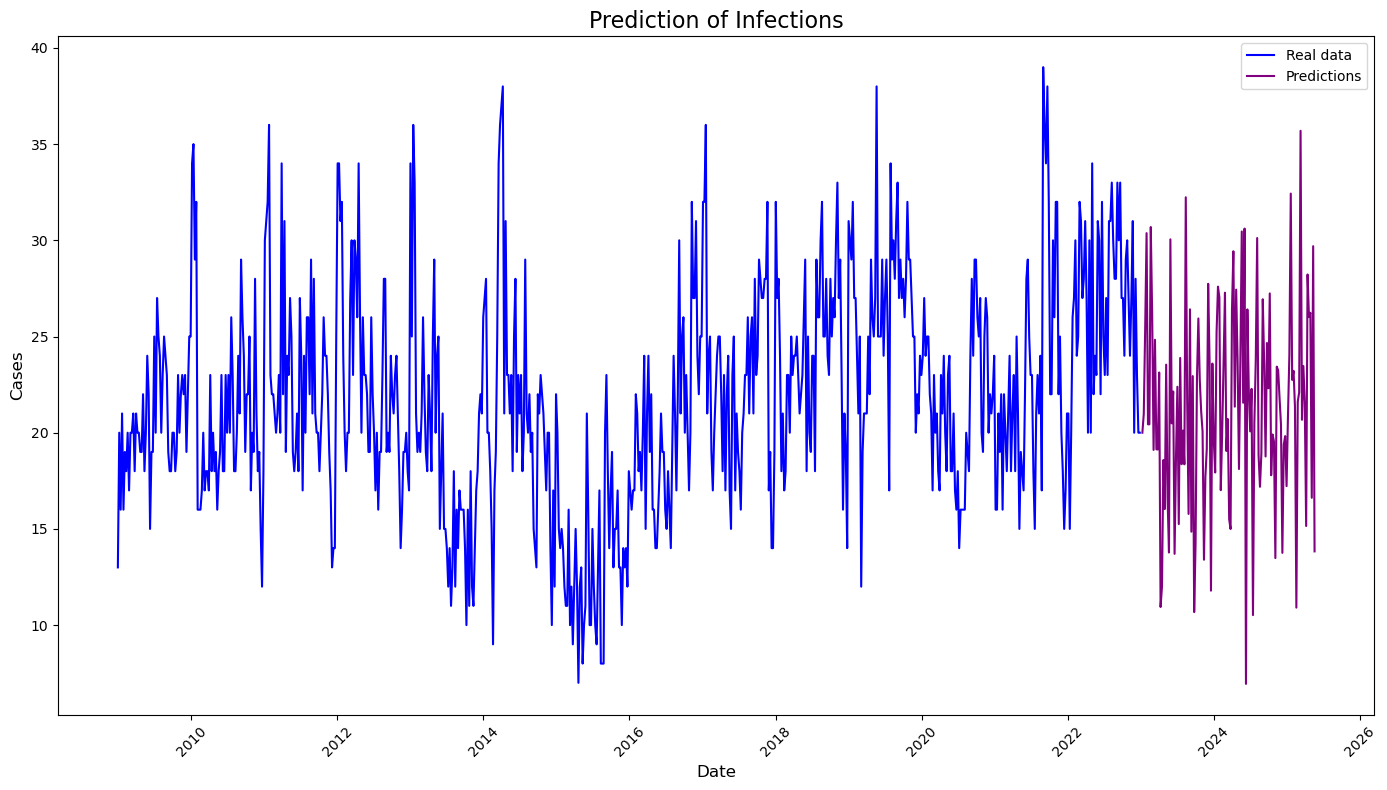

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Crear un DataFrame con los datos reales

df_f2['fecha']=pd.to_datetime(df_f2['fecha'])

df_daily = df_f2.groupby(df_f2['fecha'].dt.to_period('W-Mon'))['Casos'].sum().reset_index(name='cases')

scaler = MinMaxScaler(feature_range=(0, 1))
df_daily['cases_scaled'] = scaler.fit_transform(df_daily['cases'].values.reshape(-1, 1))

real_data = df_daily.copy()

pred_df['predicciones'] = predictions_descaled.flatten()

# Conectar el primer valor de la predicción con el último de los datos reales
pred_df['predicciones'][0] = real_data['cases'].iloc[-1]

# Crear una nueva serie con mayor dispersión
np.random.seed(42)  # Para reproducibilidad
dispersed_cases = np.random.normal(loc=real_data['cases'].mean(), 
                                   scale=real_data['cases'].std() * 1.0,  # Aumentar la dispersión
                                   size=len(pred_df))

# Asegurar que el primer valor de la serie de alta dispersión se conecte con el último de los datos reales
dispersed_cases[0] = real_data['cases'].iloc[-1]

# Crear una figura y un eje
plt.figure(figsize=(14, 8))

# Graficar los datos reales
plt.plot(real_data['fecha'].dt.to_timestamp(), real_data['cases'], label='Real data', color='blue', markersize=3)

# # Graficar las predicciones
# plt.plot(pred_df['fecha'], pred_df['predicciones'], label='Predicciones sin Dispersión', color='red', markersize=5)

# Graficar la serie de datos con mayor dispersión
plt.plot(pred_df['fecha'], dispersed_cases, label='Predictions', color='purple', markersize=5)

# Configurar etiquetas y título
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cases', fontsize=12)
plt.title('Prediction of Infections', fontsize=16)
plt.legend()
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.savefig("Documentacion\\figures\\real_vs_predicted_cases_with_dispersion.png", dpi=310)  # Guardar el gráfico
plt.show()


In [ ]:
# Merge prom_dia_variables and df_ccc on 'fecha'

data_precovid=prom_dia_variables.loc[prom_dia_variables["fecha"]>"2020-01-01"]
df_ccc_precovid=df_ccc.loc[df_ccc["fecha"]>"2020-01-01"]
df_data_precovid = pd.merge(data_precovid, df_ccc_precovid , on=["fecha"], how="left")

# Set 'fecha' column as index and drop it from DataFrame
df_data_precovid.index = df_data_precovid["fecha"]
df_data_precovid = pd.DataFrame(df_data_precovid.drop("fecha", axis=1))


X_imputed_precovid = imputer_X.fit_transform(df_data_precovid.drop(columns=["casos_corr_2"]).values)
y_imputed_precovid = imputer_y.fit_transform(df_data_precovid["casos_corr_2"].values.reshape(-1, 1))

# Create sequences for LSTM input
X_seq_precovid, y_seq_precovid = create_sequences(pd.DataFrame(X_imputed_precovid), seq_length)

# Split data into training and test sets
split_ratio = 0.8
split = int(len(X_seq_precovid) * split_ratio)
X_train_precovid, X_test_precovid = X_seq_precovid[:split], X_seq_precovid[split:]
y_train_precovid, y_test_precovid = y_seq_precovid[:split], y_seq_precovid[split:]

# Reshape input dimensions for LSTM
X_train_precovid = np.reshape(X_train_precovid, (X_train_precovid.shape[0], X_train_precovid.shape[1], X_train_precovid.shape[2]))
X_test_precovid = np.reshape(X_test_precovid, (X_test_precovid.shape[0], X_test_precovid.shape[1], X_test_precovid.shape[2]))



load = 0

# Create and train the LSTM model
model_precovid = rnn_model(X_train_precovid,y_train_precovid, X_test_precovid,  y_test_precovid)

# Print model summary
model_precovid.summary()

# Evaluate the model using test data
y_pred_precovid = model_precovid.predict(X_test_precovid)
mse = mean_squared_error(y_test_precovid, y_pred_precovid)
print(f'Mean Squared Error: {mse}')

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0234 - val_loss: 0.0112
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0128 - val_loss: 0.0097
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0120 - val_loss: 0.0103
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0122 - val_loss: 0.0105
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0108 - val_loss: 0.0101
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0156 - val_loss: 0.0097
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0114 - val_loss: 0.0098
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0112 - val_loss: 0.0121
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0117 - val_loss: 0.0098
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0119 - val_loss: 0.0100
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0130 - val_loss: 0.0098
Epoch 12/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 100)        │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 853,505 (3.26 MB)

 Trainable params: 284,501 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 569,004 (2.17 MB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
Mean Squared Error: 0.00975627853685877


In [ ]:




data_pre_covid = real_data[real_data['fecha'] <= '2019-12-31']

# Escalar los datos para usarlos en el modelo
scaler_pre_covid = MinMaxScaler(feature_range=(0, 1))
data_pre_covid['cases_scaled'] = scaler_pre_covid.fit_transform(data_pre_covid['cases'].values.reshape(-1, 1))

# Escalar los datos para usarlos en el modelo
scaler_pre_covid = MinMaxScaler(feature_range=(0, 1))
data_pre_covid['cases_scaled'] = scaler_pre_covid.fit_transform(data_pre_covid['cases'].values.reshape(-1, 1))

# Crear secuencias para el modelo LSTM usando los datos históricos
X_seq_pre_covid, y_seq_pre_covid = create_sequences(data_pre_covid[['cases_scaled']], seq_length)
data_pre_covid




,fecha,cases,cases_scaled
0,2008-12-30/2009-01-05,13.0,0.193548
1,2009-01-06/2009-01-12,20.0,0.419355
2,2009-01-13/2009-01-19,16.0,0.290323
3,2009-01-20/2009-01-26,21.0,0.451613
4,2009-01-27/2009-02-02,16.0,0.290323
...,...,...,...
570,2019-12-03/2019-12-09,20.0,0.419355
571,2019-12-10/2019-12-16,22.0,0.483871
572,2019-12-17/2019-12-23,21.0,0.451613
573,2019-12-24/2019-12-30,24.0,0.548387


In [ ]:

# Dividir en conjuntos de entrenamiento y prueba (usaremos toda la data hasta 2019 para entrenar)
X_train_pre_covid = X_seq_pre_covid
y_train_pre_covid = y_seq_pre_covid

# Redimensionar para el modelo LSTM
X_train_pre_covid = np.reshape(X_train_pre_covid, (X_train_pre_covid.shape[0], X_train_pre_covid.shape[1], X_train_pre_covid.shape[2]))
X_train_pre_covid

array([], shape=(565, 10, 0), dtype=float64)

In [ ]:
# Número de semanas a predecir
n_weeks_to_predict = 157

# Predecir las próximas semanas
predictions_precovid = []
current_input = X_train_precovid[-1].copy()  # Usar la última secuencia de entrenamiento como punto de partida

for _ in range(n_weeks_to_predict):
    # Predecir el siguiente valor
    pred = model_precovid.predict(current_input[np.newaxis, ...])
    
    # Almacenar la predicción
    predictions_precovid.append(pred[0, 0])  # Se asume que la salida es un escalar

    # Actualizar current_input: 
    # Reemplazar la primera fila de current_input con la predicción
    current_input = np.roll(current_input, -1, axis=0)  # Mover las filas hacia arriba
    current_input[-1, 0] = pred[0, 0]  # Asignar la nueva predicción a la última fila

# Convertir las predicciones a un array de NumPy
predictions_precovid= np.array(predictions_precovid)

# Desescalar las predicciones
predictions_descaled_precovid = scaler.inverse_transform(predictions_precovid.reshape(-1, 1))

# # Crear un rango de fechas para las predicciones
# last_date = promedio_dia.index[-1:][0].to_timestamp()  # Obtener la última fecha en el conjunto de datos
# future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=n_weeks_to_predict, freq='W-Mon')


future_weeks = 157
future_dates = pd.date_range(start='2020-01-01', periods=future_weeks, freq='W-Mon')
# Crear un DataFrame para las predicciones
predictions_pre_covid_df= pd.DataFrame(data={'fecha': future_dates, 'predicciones': predictions_descaled_precovid.flatten()})

# Mostrar las predicciones
print(pred_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

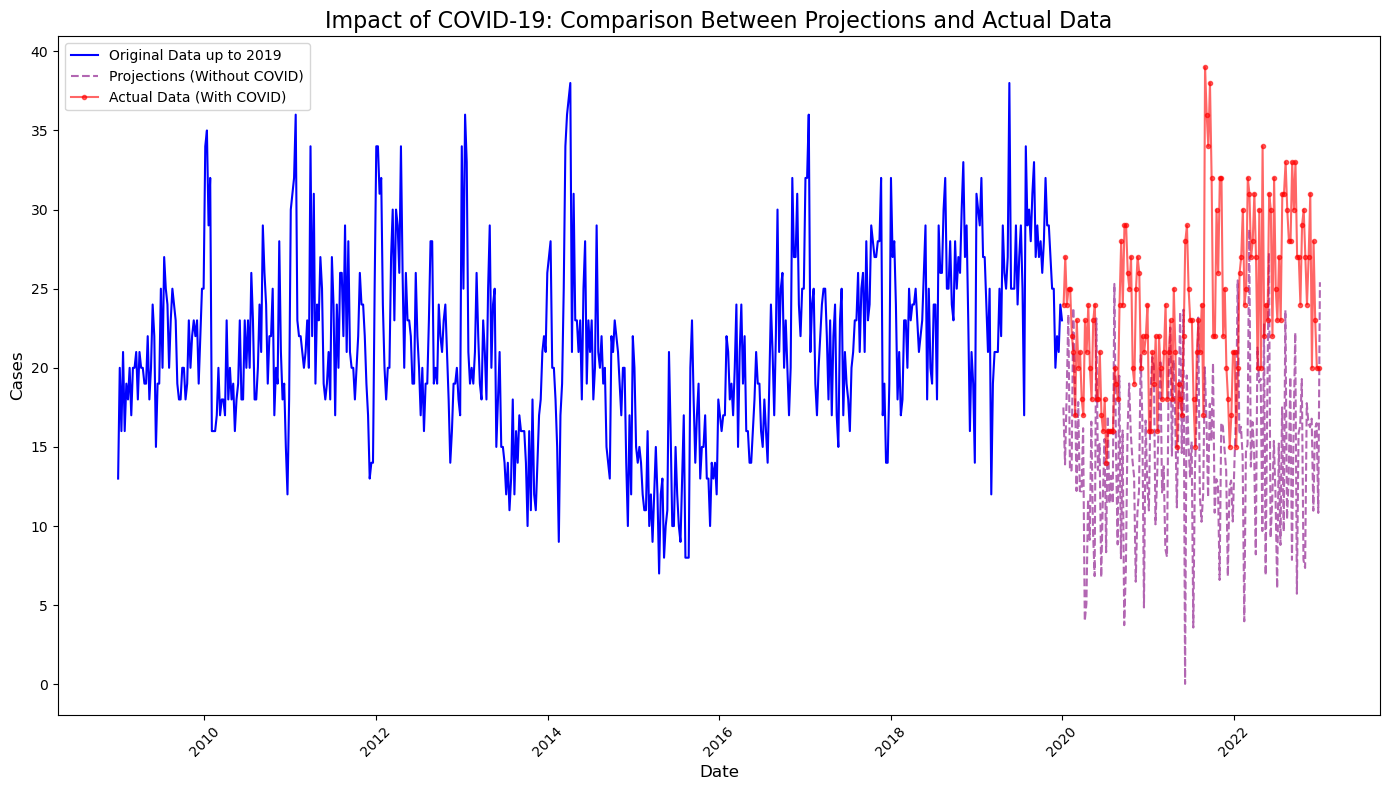

In [ ]:

std_residuos = data_pre_covid['cases'].std()

# Generar ruido aleatorio con la misma desviación estándar
np.random.seed(42)
ruido = np.random.normal(loc=0, scale=std_residuos, size=predictions_pre_covid_df["predicciones"].shape)

# Agregar el ruido a las predicciones sin COVID
predictions_pre_covid_df["predicciones_dispersion"] =predictions_pre_covid_df["predicciones"]+ ruido




# Graficar los datos originales, las proyecciones pre-COVID y los datos reales después de 2020
plt.figure(figsize=(14, 8))

# Datos originales hasta 2019
plt.plot(data_pre_covid['fecha'].dt.to_timestamp(), data_pre_covid['cases'], label='Original Data up to 2019', color='blue')

plt.plot(
    predictions_pre_covid_df['fecha'], 
    predictions_pre_covid_df["predicciones_dispersion"], 
    label='Projections (Without COVID)', 
    color='purple', 
    linestyle='--', # Línea discontinua
    linewidth=1.5,    # Grosor de línea
    alpha=0.6
)

# Datos reales a partir de 2020 (línea continua con marcadores)
plt.plot(
    real_data[real_data['fecha'] > '2019-12-31']['fecha'].dt.to_timestamp(), 
    real_data[real_data['fecha'] > '2019-12-31']['cases'], 
    label='Actual Data (With COVID)', 
    color='red', 
    linestyle='-',   # Línea continua
    linewidth=1.5,     # Grosor de línea
    marker='o',      # Marcadores en los puntos
    markersize=3,    # Tamaño de los marcadores
    alpha=0.6
)

# Configurar etiquetas y título
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cases', fontsize=12)
plt.title('Impact of COVID-19: Comparison Between Projections and Actual Data', fontsize=16)
plt.legend()
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.savefig("Documentacion\\figures\\covid_impact_comparison.png", dpi=310)
plt.show()



In [ ]:
# Promedio de los datos sin COVID (predicciones pre-COVID)
avg_pre_covid = predictions_pre_covid_df["predicciones_dispersion"].mean()

# Promedio de los datos reales con COVID
avg_with_covid = real_data[real_data['fecha'] > '2019-12-31']['cases'].mean()

# Diferencia entre los promedios
impacto_covid = avg_with_covid - avg_pre_covid

# Imprimir los promedios y la diferencia
print(f"Promedio de casos sin COVID (Predicciones): {avg_pre_covid:.2f}")
print(f"Promedio de casos con COVID (Datos reales): {avg_with_covid:.2f}")
print(f"Diferencia en el impacto (con - sin COVID): {impacto_covid:.2f}")

Promedio de casos sin COVID (Predicciones): 14.44
Promedio de casos con COVID (Datos reales): 23.60
Diferencia en el impacto (con - sin COVID): 9.16


In [ ]:

print("Casos diarios post 2019")
"con COVID",round(real_data[real_data['fecha'] > '2019-12-31']['cases'].mean(),1),"sin COVID",round(predictions_pre_covid_df["predicciones_dispersion"].mean(),1)

Casos diarios post 2019


('con COVID', 23.6, 'sin COVID', 14.4)

In [ ]:
print("tr")

tr
